# Prediction of imputed pixels

Training of the imputation predictor to verify the Mask Information Term.

In this notebook we train a simple predictor that shows how hard / easy it is to predict imputed pixels when using different strategies.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../") # Change to main folder to use road package. Alternatively set PYTHONPATH accordingly.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

from road import ImputedDataset
from road.imputations import NoisyLinearImputer, ChannelMeanImputer, ZeroImputer
from road.utils import load_expl
device="cuda:1"

In [4]:
from imputation_predict import create_data_sets

## Create train and test sets for original images, linear and fixed value imputation.

In [5]:
train_set_org, test_set_org = create_data_sets(p=0.3)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def show_img(ax, x):
    ax.imshow((x.transpose(0,1).transpose(1,2)).numpy())

Visualize the same sample from each of the data sets.

torch.Size([3, 32, 32]) torch.Size([32, 32])


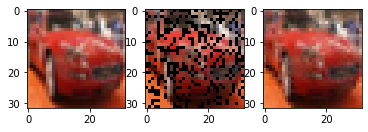

In [7]:
data_idx = 5
image = train_set_org[data_idx][0]
mask = train_set_org[data_idx][3]
print(image.shape, mask.shape)
f, (ax1, ax2, ax3) = plt.subplots(1,3)
show_img(ax1, image)
show_img(ax2, ZeroImputer()(image,mask))
show_img(ax3, NoisyLinearImputer()(image,mask))
plt.show()

Plot the difference between imputed and original.

## Train an imputation predictor

We want to train a model that computs whether a pixel is imputed or not.

In [8]:
# The simple imputation predictor network. It has one probabilistic output for each input.
from imputation_predict import ImputationPredictor, test_imp_predictor, train_imp_predictor

## Train it for the linear imputation model.

In [26]:
batch_size = 24
#del trainloader
#del testloader
trainloader = torch.utils.data.DataLoader(train_set_org, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(test_set_org, batch_size=batch_size, shuffle=False, num_workers=8)

In [27]:
imppred = ImputationPredictor(th_p=0.3)

In [28]:
ret = imppred(train_set_org[data_idx][0].unsqueeze(0))

In [29]:
ret

tensor([[[[0.6029, 0.6032, 0.6032,  ..., 0.6031, 0.6031, 0.6031],
          [0.6030, 0.6029, 0.6029,  ..., 0.6029, 0.6028, 0.6028],
          [0.6030, 0.6029, 0.6028,  ..., 0.6028, 0.6026, 0.6027],
          ...,
          [0.6034, 0.6035, 0.6035,  ..., 0.6039, 0.6039, 0.6032],
          [0.6034, 0.6034, 0.6035,  ..., 0.6040, 0.6040, 0.6033],
          [0.6041, 0.6039, 0.6039,  ..., 0.6039, 0.6039, 0.6031]]]],
       grad_fn=<SigmoidBackward>)

In [30]:
myopt = optim.Adam(imppred.parameters(), lr = 1e-3)

In [ ]:
# Train until loss converges.
#my_imputer = NoisyLinearImputer(noise=0.05)
my_imputer = ZeroImputer()
for epoch in range(20):
    imppred = train_imp_predictor(imppred, myopt, trainloader, use_imputation=my_imputer)
    if epoch % 2 == 0:
        print("Test acc:", test_imp_predictor(imppred, testloader, use_imputation=my_imputer)*100)

In [33]:
print("Test acc:", test_imp_predictor(imppred, testloader, use_imputation=my_imputer)*100)

100%|██████████| 417/417 [00:01<00:00, 306.81it/s]

Test acc: 99.828505859375


### Visualize predictions vs actual imputations.

tensor(0.6773)
tensor([[[[0.0012, 1.0000, 1.0000,  ..., 0.0012, 1.0000, 1.0000],
          [1.0000, 0.9630, 0.0012,  ..., 0.0012, 1.0000, 1.0000],
          [1.0000, 0.0012, 0.0012,  ..., 1.0000, 1.0000, 0.0012],
          ...,
          [0.9575, 0.0012, 0.0012,  ..., 0.9575, 0.9575, 0.0012],
          [0.9575, 0.0012, 0.9575,  ..., 0.9575, 0.0012, 0.0012],
          [0.9575, 0.9575, 0.0012,  ..., 0.9575, 0.9575, 0.9575]]]])


Text(0.5, 1.0, 'Ground Truth')

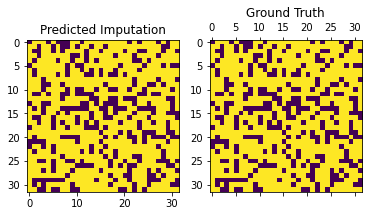

In [34]:
iid=4

f, (ax1, ax2) = plt.subplots(1,2)
x, _, _, mask = train_set_org[iid]
impred = imppred.to(device)
res = imppred(my_imputer(x, mask).unsqueeze(0).to(device)-0.5).detach().cpu()
print(res.mean())
print(res)
ax1.imshow((res>0.5).float().squeeze(0).transpose(0,1).transpose(1,2))
#ax1.imshow(my_imputer(x, mask).transpose(0,1).transpose(1,2))
ax1.set_title("Predicted Imputation")
ax2.matshow(mask)
ax2.set_title("Ground Truth")

In [35]:
correct = ((res>0.5) == mask).sum().item()
print(correct/np.prod(mask.shape))

1.0


Please see the script ``imputation_predict.py`` to for the imputation prediction of the predictor for all other imputation methods.